In [1]:
from google.colab import files
files.upload() # Upload kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shayanfazeli/heartbeat
!unzip heartbeat.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
Archive:  heartbeat.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


In [3]:
import torch as t

device = t.device("mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu")

print(device)

cuda


Import ECG data and convert to continous stream by removing padding zeros and concatonating - and adding back some padding at the last value with some noise, to try to emulate the inter-beat intervals.

Add a label for each sample as to whether it is part of abnormal heartbeat (1) or not (0)

torch.Size([18534425])
torch.Size([18534425])


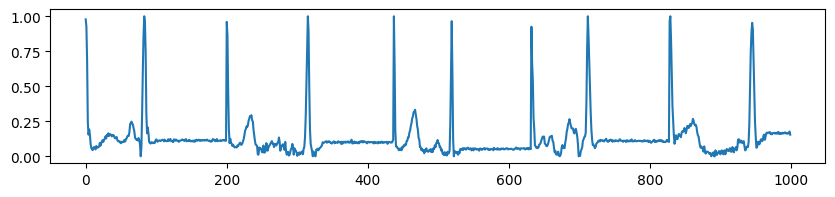

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('mitbih_train.csv', header=None)
data = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values
labels = np.where(labels == 0, 0, 1) # Convert to binary (normal/abnormal)

# Remove zeros and add padding
padding_length = 100
padding_std = 0.005
data_stream = []
data_labels = []
for index, row in enumerate(data):
    nonzero_indices = np.nonzero(row)[0] # Get Indices of non-zero values
    trimmed_row = row[:nonzero_indices[-1] + 1] # Slice up to last non zero

    # Add some random padding between heartbeats
    padding = np.random.normal(trimmed_row[-1], padding_std, size=padding_length)
    padded_row = np.concatenate((trimmed_row, padding))

    # Create label vector for samples that are part of abnormal heartbeat
    if labels[index] == 0:
        label_vector = np.zeros(len(trimmed_row))
    else:
        label_vector = np.ones(len(trimmed_row))
    padded_labels = np.concatenate((label_vector, np.zeros(padding_length)))

    # Add to continuous stream
    data_stream.extend(padded_row)
    data_labels.extend(padded_labels)

data_stream = t.tensor(data_stream, dtype=t.float32)
data_labels = t.tensor(data_labels, dtype=t.float32)
print(data_stream.shape)
print(data_labels.shape)

# Plot some of the data
plt.figure(figsize=(10, 2))
plt.plot(data_stream[:1000])
plt.show()


First I want to check how successful the model trained on the cropped heartbeats is so load the model weights from the previous notebook.


In [11]:
import torch.nn as nn

class ECGClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.net(x)

files.upload() # Upload ecg_cnn.pth
model = ECGClassifier().to(device)
model.load_state_dict(t.load('ecg_cnn.pth'))
model.eval()

Saving ecg_cnn.pth to ecg_cnn.pth


ECGClassifier(
  (net): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU()
    (5): AdaptiveAvgPool1d(output_size=1)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=32, out_features=2, bias=True)
  )
)

We will need a modified DataLoader that takes a random 188 length sample from the continuous data and returns whether it contains an abnormal heartbeat.

In [12]:
from torch.utils.data import Dataset, DataLoader

class ContinuousECGDataset(Dataset):
    def __init__(self, data, labels, window_size=188, num_samples=1000):
        self.data = data
        self.labels = labels
        self.window_size = window_size
        self.max_start_sample = len(data) - window_size
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Take a random sample from time series data
        start_sample = np.random.randint(0, self.max_start_sample)
        X = self.data[start_sample:start_sample+self.window_size]
        # Window is labeled abnormal if any sample is
        y_window = self.labels[start_sample:start_sample+self.window_size]
        y = 1 if t.any(y_window == 1) else 0
        return X.unsqueeze(0), y  # Add channel dim

test_ds = ContinuousECGDataset(data_stream, data_labels, window_size=188, num_samples=1000)
test_loader = DataLoader(test_ds, batch_size=64)

Now we can test the accuracy using the same code as before.

ROC-AUC: 0.862
Accuracy: 0.817
Sensitivity: 0.739, Specificity: 0.835


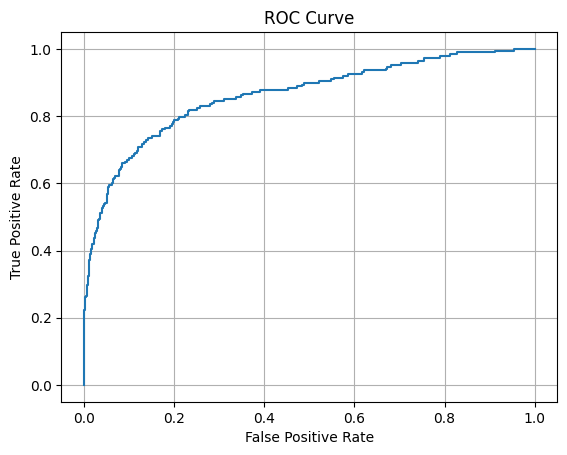

In [16]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_scores = [], []

    with t.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            probs = preds.softmax(dim=1)[:, 1]
            y_true.extend(yb.tolist())
            y_scores.extend(probs.tolist())

    # Metrics
    auc = roc_auc_score(y_true, y_scores)
    print(f"ROC-AUC: {auc:.3f}")

    # Confusion matrix
    y_pred = [1 if p > 0.5 else 0 for p in y_scores]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Sensitivity: {sensitivity:.3f}, Specificity: {specificity:.3f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.grid()
    plt.show()

evaluate_model(model, test_loader)

This is a bit less accurate than before which is what I would expect as it will contain windows with only a bit of an abnormal heartbeat in and they are not as centred as they are in the original training data. The padding I added could also potentially be leading to more inaccuracies.

Next I'm going to try to detect a peak for each window to see if having the data more similar to training data improves the model performance.

ROC-AUC: 0.870
Accuracy: 0.885
Sensitivity: 0.649, Specificity: 0.927


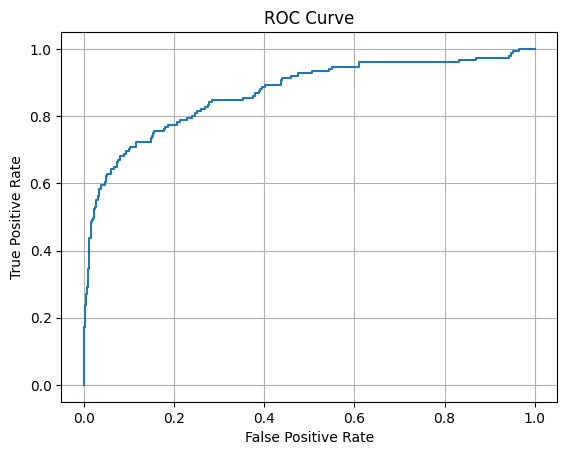

In [17]:
class PeakDetectECGDataset(Dataset):
    def __init__(self, data, labels, window_size=188, num_samples=1000):
        self.data = data
        self.labels = labels
        self.window_size = window_size
        self.max_start_sample = len(data) - 2*window_size
        self.num_samples = num_samples
        self.peak_threshold = 0.75 # Guess from looking at plotted data

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Take a random start sample and find next peak
        start_sample = np.random.randint(0, self.max_start_sample)
        after_sample = self.data[start_sample:]
        above_threshold = t.where(after_sample > self.peak_threshold)[0]
        start_sample = start_sample + above_threshold[0].item()
        X = self.data[start_sample:start_sample+self.window_size]
        # Window is labeled abnormal if any sample is
        y_window = self.labels[start_sample:start_sample+self.window_size]
        y = 1 if t.any(y_window == 1) else 0
        return X.unsqueeze(0), y  # Add channel dim

test_peak_ds = PeakDetectECGDataset(data_stream, data_labels, window_size=188, num_samples=1000)
test_peak_loader = DataLoader(test_peak_ds, batch_size=64)

evaluate_model(model, test_peak_loader)

This is a bit better than before and is an algorithm that could be applied to real time data as long as there was enough computing power.